In [21]:
import pandas as pd
import numpy as np 
import PIL
import h5py
import time
from scipy import ndimage
from scipy.interpolate import griddata
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt 
from PIL import Image

In [2]:
def getting_2D_data_from_h5_filtered_np_xy_switched(h5_path, part_name,
                                                    slice_name, intensity_limit, area_limit, show_info=False):

    # setting the start timer for time information
    start_time = time.time()

    # opening HDF5 file
    with h5py.File(h5_path, 'r') as h5:

        # check whether slice exists -> if not: empty array returned
        if slice_name in h5[part_name]:
            # X and Y Axis are changed to fit the OpenCV coordinate system
            X_Axis = np.array(h5[part_name][slice_name]['Y-Axis'][:]).astype(int)
            Area = np.array(h5[part_name][slice_name]['Area'][:]).astype(int)
            Intensity = np.array(h5[part_name][slice_name]['Intensity'][:]).astype(int)
            Y_Axis = np.array(h5[part_name][slice_name]['X-Axis'][:]).astype(int)

            # The following if condition is added because pre investigations showed that in some very rare cases
            # the dimensions of the arrays weren't exactly the same as there was an extra point on top of one of the
            # arrays. The dimension inequality led to instabilities.
            # If dimensions aren't equal the following code block is entered

            if not X_Axis.size == Y_Axis.size == Area.size == Intensity.size:

                # determine the lowest value among the different sizes
                size_arr = np.array([X_Axis.size, Y_Axis.size, Area.size, Intensity.size])
                min_size = size_arr.min()

                if X_Axis.size != min_size:
                    diff_size_x = X_Axis.size - min_size
                    X_Axis = np.delete(X_Axis, -diff_size_x)

                if Y_Axis.size != min_size:
                    diff_size_y = Y_Axis.size - min_size
                    Y_Axis = np.delete(Y_Axis, -diff_size_y)

                if Area.size != min_size:
                    diff_size_area = Area.size - min_size
                    Area = np.delete(Area, -diff_size_area)

                if Intensity.size != min_size:
                    diff_size_intensity = Intensity.size - min_size
                    Intensity = np.delete(Intensity, -diff_size_intensity)

            if show_info:
                print(str(X_Axis.size) + ' total data points found')

            # The following line of code stacks the single arrays to a table like structure.
            combos = np.stack((X_Axis, Y_Axis, Area, Intensity), axis=-1)

            # The following block filters out single outlier points by comparing the X and Y-values to min and max
            # values.
            median_x = np.median(combos[:, 0])
            median_y = np.median(combos[:, 1])
            std_x = int(combos[:, 0].std())
            std_y = int(combos[:, 1].std())
            low_limit_x = median_x - 2 * std_x
            low_limit_y = median_y - 2 * std_y
            high_limit_x = median_x + 2 * std_x
            high_limit_y = median_y + 2 * std_y

            combos = np.delete(combos, np.where(combos[:, 0] < low_limit_x), axis=0)
            combos = np.delete(combos, np.where(combos[:, 0] > high_limit_x), axis=0)
            combos = np.delete(combos, np.where(combos[:, 1] < low_limit_y), axis=0)
            combos = np.delete(combos, np.where(combos[:, 1] > high_limit_y), axis=0)

            # The following block filters out points where Area and Intensity values are equal to 0.
            area_zeros = np.where(combos[:, 2] == 0)
            intensity_zeros = np.where(combos[:, 3] == 0)
            zero_area_intensity_indices = np.intersect1d(area_zeros, intensity_zeros)
            combos_wo_only_zeros = np.delete(combos, zero_area_intensity_indices, axis=0)

            if show_info:
                print(str(combos_wo_only_zeros.shape[0]) + ' data points where area != 0 AND intensity != 0')

            # The following block is used for handling x,y-combinations occurring multiple times
            _, unique_indices = np.unique(combos_wo_only_zeros[:, [0, 1]], axis=0, return_index=True)
            combos_unique = combos_wo_only_zeros[unique_indices]

            if show_info:
                print(str(combos_unique.shape[0]) + ' unique x,y-combinations where area != 0 AND intensity != 0')

            # getting all the indices belonging to non unique x,y-combinations
            index_range = np.arange(combos_wo_only_zeros.shape[0])
            indices_of_interest = np.setdiff1d(index_range, unique_indices)

            combo_processed_array = np.empty([0, 4], dtype=int)
            return_array = np.copy(combos_wo_only_zeros)
            index_counter = 0
            indices_list = []

            if show_info:
                print("vor iterieren %s seconds ---" % (time.time() - start_time))

            # looping through all the indices belonging to non unique x,y-combinations
            for index in indices_of_interest:
                xy_combo = combos_wo_only_zeros[:, [0, 1]][index]
                # checking whether x,y combination has already been checked, if yes -> no action
                if np.where((combo_processed_array[:, 0] == xy_combo[0]) * (combo_processed_array[:, 1] == xy_combo[1]))[0].size == 0:
                    index_counter += 1
                    xy_combo = combos_wo_only_zeros[:, [0, 1]][index]

                    # getting all the indices of the currently checked x,y-combination
                    indices_relevant = np.where((combos_wo_only_zeros[:, 0] == xy_combo[0]) * (combos_wo_only_zeros[:, 1] == xy_combo[1]))[0]

                    # getting the max Area and Intensity of the currently checked x,y-combination
                    # this block would need to be replaced in case mean values are desired
                    max_area_of_combo = np.amax(combos_wo_only_zeros[:, 2][indices_relevant])
                    max_intensity_of_combo = np.amax(combos_wo_only_zeros[:, 3][indices_relevant])

                    # stacking x, y, maxArea and maxIntensity together
                    max_combos = np.stack((xy_combo[0], xy_combo[1], max_area_of_combo, max_intensity_of_combo), axis=-1)

                    # stacking the created combination on top of the copy of combos_wo_only_zeros
                    return_array = np.vstack((return_array, max_combos))

                    # adding the relevant indices to the indices_list and adding the created combination to combo_processed_array
                    indices_list.append(list(indices_relevant))
                    combo_processed_array = np.vstack((combo_processed_array, max_combos))

            # creating a an array with all the indices of multiple points and deleting those positions from combos_
            # wo_only_zeros_copy -> this way all the old x,y combinations occurring multiple times are replaced by the
            # generated combination with max Values
            indices_relevant = np.hstack(indices_list)
            return_array = np.delete(return_array, indices_relevant, axis=0)

            # filtering out intensity outlier points
            for row in return_array:
                if row[3] > intensity_limit:
                    row[3] = intensity_limit
                # added block to filter out area outlier points
                if row[2] > area_limit:
                    row[2] = area_limit

        else:
            return_array = np.empty([0, 4], dtype=int)
            print('{} is not existing -> empty array created'.format(slice_name))

        if show_info:
            print("array creation took %s seconds ---" % (time.time() - start_time))

    return return_array


################

def get_min_max_values_xy_selected_slices(h5_path, part_name,  min_slice_num, max_slice_num, intensity_limit, area_limit):
    df = pd.DataFrame(columns=['Slice_num', 'minX', 'maxX', 'minY', 'maxY', 'diameterX', 'diameterY'])

    # iterating over all slices in selected range
    for num_slice in range(min_slice_num, max_slice_num+1):
        slice_name = 'Slice' + str("{:05d}".format(num_slice))
        array = getting_2D_data_from_h5_filtered_np_xy_switched(h5_path, part_name, slice_name, intensity_limit, area_limit)

        # calculating minX, minY, maxX and maxY for every slice
        minX = array[:, 0].min()
        maxX = array[:, 0].max()
        minY = array[:, 1].min()
        maxY = array[:, 1].max()
        diameterX = maxX - minX
        diameterY = maxY - minY

        # appending the values to a pandas Dataframe
        df = df.append({'Slice_num': "{:05d}".format(num_slice), 'minX': minX, 'maxX': maxX, 'minY': minY, 'maxY': maxY,
                        'diameterX': diameterX, 'diameterY': diameterY}, ignore_index=True)

    # print(df['minX'].min())
    # print(df['minY'].min())
    # print(df['maxX'].max())
    # print(df['maxY'].max())

    # returning just the minimum/maximum values of the whole Dataframe to get the desired result
    return df['minX'].min(), df['minY'].min(), df['maxX'].max(), df['maxY'].max()


####################


def dock_array_to_zero(array, minX, minY):
    if minX >= 0 and minY >= 0:
        array[:, 0] = array[:, 0] - minX
        array[:, 1] = array[:, 1] - minY
    elif minX < 0 and minY < 0:
        array[:, 0] = array[:, 0] + abs(minX)
        array[:, 1] = array[:, 1] + abs(minY)
    elif minX >= 0 and minY < 0:
        array[:, 0] = array[:, 0] - minX
        array[:, 1] = array[:, 1] + abs(minY)
    elif minX < 0 and minY >= 0:
        array[:, 0] = array[:, 0] + abs(minX)
        array[:, 1] = array[:, 1] - minY
    return array

In [3]:
def create_single_grid_array(cur_n_grid_x, cur_n_grid_y, grid_size, array, y_max):
    # getting the minimum and maximum x of the current grid
    x_min_grid = cur_n_grid_x * grid_size
    x_max_grid = (cur_n_grid_x + 1) * grid_size

    # the added y_max - operation enables counting from the left upper corner onwards
    y_min_grid = y_max - (cur_n_grid_y + 1) * grid_size
    y_max_grid = y_max - cur_n_grid_y * grid_size

    # print(x_min_grid)
    # print(x_max_grid)
    # print(y_min_grid)
    # print(y_max_grid)

    grid_array = np.empty([0, 4], dtype=int)

    # check if data points in array are in the region of the grid
    indices_relevant = np.where((array[:, 0] >= x_min_grid) * (array[:, 0] < x_max_grid) * (array[:, 1] >= y_min_grid) * (array[:, 1] < y_max_grid))[0]
    if indices_relevant.size != 0:
        relevant_array = array[indices_relevant]
        relevant_array[:, 0] = relevant_array[:, 0] - x_min_grid
        relevant_array[:, 1] = relevant_array[:, 1] - y_min_grid

        final_grid_array = relevant_array
    else:
        final_grid_array = grid_array

    return final_grid_array

################

def process_data_to_picturelike_structure(array, grid_size, kernel_size, intensity_limit, area_limit, int_area_switch):
    # creating a picture grid with only zeros as a base for data filling
    picturelike_grid = np.zeros((grid_size, grid_size), dtype=np.uint8)

    # filling in the points from final grid, row[3]
    # the *255/intensity_limit product scales the values with respect to the intensity limit
    for row in array:
        if int_area_switch:
            picturelike_grid[row[0], row[1]] = int(row[3] * 255 / intensity_limit)
        else:
            picturelike_grid[row[0], row[1]] = int(row[2] * 255 / area_limit)

    dilated_array = ndimage.grey_dilation(picturelike_grid, size=(kernel_size, kernel_size))

    return dilated_array

In [4]:
h5_path = '/home/jan/Documents/Diplomarbeit/Trainingsdaten/ZPs/ZP1/ZP_1_full_part.h5'
part_name = 'ZP1_combined'
slice_name = 'Slice00'+str(533)
min_slice = 527
max_slice = 1126
intensity_limit = 1750
area_limit = 1500

In [5]:
minX, minY, maxX, maxY = get_min_max_values_xy_selected_slices(h5_path, part_name, min_slice_num = min_slice,
                                 max_slice_num = max_slice, intensity_limit= intensity_limit, area_limit = area_limit)

In [6]:
array_undocked = getting_2D_data_from_h5_filtered_np_xy_switched(h5_path, part_name, slice_name, intensity_limit = intensity_limit, area_limit = area_limit, show_info=True)
array_docked = dock_array_to_zero(array_undocked, minX, minY)

8801 total data points found
5359 data points where area != 0 AND intensity != 0
4912 unique x,y-combinations where area != 0 AND intensity != 0
vor iterieren 0.0055963993072509766 seconds ---
array creation took 0.01934981346130371 seconds ---


<function matplotlib.pyplot.show(*args, **kw)>

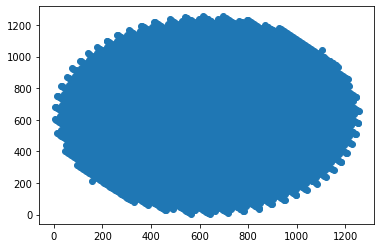

In [7]:
plt.scatter(array_docked[:,0], array_docked[:,1])
plt.show

In [8]:
print(maxX-minX)
print(maxY-minY)

1260
1259


In [9]:
length_x_part = maxX-minX
length_y_part = maxY-minY

In [10]:
min_square = int(0.15*length_x_part)  # 0.15 and 0.85 are derived from pythagoras and sqrt of 2 when cutting the square out of the circle
max_square = int(0.85*length_x_part)

(0.0, 1260.0, 0.0, 1260.0)

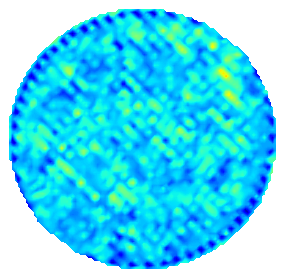

In [67]:
# This block of code displays the Area data of a single slice and interpolates the missing areas for better visualization 

figure(num=None, figsize=(5, 5), dpi=70, facecolor='w', edgecolor='k')

x = array_docked[:,0]
y = array_docked[:,1]
z = array_docked[:,2]

xi = np.linspace(0,1260,100)
yi = np.linspace(0,1260,100)
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')
cntr1 = plt.contourf(xi, yi, zi, levels=200, cmap="jet")
#plt.title(("Area of ZP{} at {}").format(1, slice_name))
plt.clim(0,1500)
#plt.colorbar()
#plt.show()
plt.axis('off')

#plt.savefig(("RGB_area_images/Area of ZP{} at {}_cut.png").format(1, slice_name), bbox_inches='tight', pad_inches=0 )

In [68]:
img = Image.open('/home/jan/Documents/Diplomarbeit/Code_zusammengefasst/QM-Meltpool-Datenaufbereitung/RGB_area_images/Area of ZP1 at Slice00533_cut.png')
img = img.resize((128, 128), PIL.Image.LANCZOS) 
raw_array = np.asarray(img)
#array = cv2.cvtColor(raw_array, cv2.COLOR_BGRA2BGR)

In [69]:
raw_array

array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

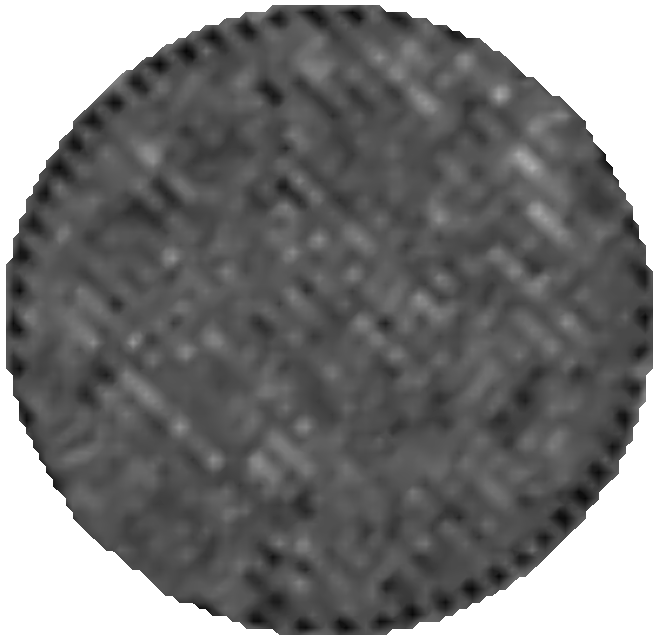

In [72]:
img = Image.open('/home/jan/Documents/Diplomarbeit/Code_zusammengefasst/QM-Meltpool-Datenaufbereitung/RGB_area_images/Area of ZP1 at Slice00533_cut.png').convert('L')
raw_array = np.asarray(img)
img

In [73]:
raw_array

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [55]:
cut_array = raw_array[:,:,0]

In [56]:
cut_array

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

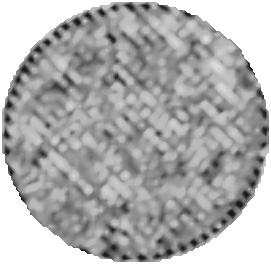

In [58]:
image = Image.fromarray(cut_array)
image

TypeError: Image data of dtype object cannot be converted to float

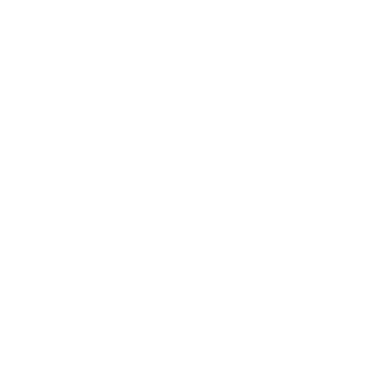

In [48]:
fig = plt.figure(frameon=False)
fig.set_size_inches(5,5)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

ax.imshow(cntr1, aspect='auto')
fig.savefig("RGB_area_images/Area", 100)

In [ ]:
min_square = int(0.15*length_x_part)  # 0.15 and 0.85 are derived from pythagoras and sqrt of 2 when cutting the square out of the circle
max_square = int(0.85*length_x_part)